## contamination checks

In [369]:
import sys,os,shutil,subprocess
import glob
from importlib import reload
import numpy as np
import pandas as pd
pd.set_option('display.width', 200)
import pylab as plt
import seaborn as sns
from Bio import SeqIO, AlignIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from snipgenie import tools, aligners, app, trees, plotting, tools, rdiff
from importlib import reload
import gzip, tempfile
import pylab as plt

In [2]:
samples = pd.read_csv('/storage/btbgenie/monaghan/monaghan_results/samples.csv')

In [89]:
f1='/storage/btbgenie/mbovis_ireland/Monaghan/Fastqs_29-07-19/1579_S5_L001-4_R1_001.fastq.gz'
f2='/storage/btbgenie/mbovis_ireland/Monaghan/Fastqs_29-07-19/1579_S5_L001-4_R2_001.fastq.gz'
#f1='/storage/btbgenie/mbovis_ireland/Monaghan/Fastqs_29-07-19/362p_S18_L001-4_R1_001.fastq.gz'
#f2='/storage/btbgenie/mbovis_ireland/Monaghan/Fastqs_29-07-19/362p_S18_L001-4_R2_001.fastq.gz'


In [4]:
def spades(file1, file2, path, outfile=None, threads=4):
    """Run spades"""
    
    cmd = 'spades -t %s --pe1-1 %s --pe1-2 %s --careful -o %s' %(threads,file1,file2,path)    
    if not os.path.exists(path): 
        print (cmd)
        subprocess.check_output(cmd, shell=True)
    if outfile != None:
        shutil.copy(os.path.join(path,'scaffolds.fasta'),outfile)
    return outfile

In [ ]:
#assemble 
name='1579'
assembly_path='assembly'
out = os.path.join(assembly_path,name+'.fa')
spades(f1,f2, os.path.join(assembly_path,name), outfile=out, threads=12)

## kraken2

In [59]:
def kraken(file1, file2, threads=4):
    """Run kraken2 on paired reads"""
    
    os.environ['KRAKEN2_DB_PATH'] = '/local/kraken2'
    cmd = 'kraken2 -db STANDARD16 --report krakenreport.txt --threads {t} --paired {f1} {f2} > kraken.out'.format(f1=file1,f2=file2,t=threads)
    print (cmd)
    subprocess.check_output(cmd, shell=True)
    rep=pd.read_csv('krakenreport.txt',sep='\t',names=['perc_frag','n_frags_root','n_frags','rank_code','taxid','name'])   
    rep['name'] = rep.name.str.lstrip()
    return rep

#rep=kraken(f1, f2)

In [156]:
rep=rep[rep.perc_frag>0.1]
rep[rep.rank_code=='G']

,perc_frag,n_frags_root,n_frags,rank_code,taxid,name,sample
9,99.72,648439,2172,G,1763,Mycobacterium,3266


In [ ]:
res=[]
found = pd.read_csv('contam_monaghan_kraken.csv')
samples = pd.read_csv('/storage/btbgenie/monaghan/monaghan_results/samples.csv')
meta = ps.read_csv('/storage/btbgenie/monaghan/metadata/master.csv')
for i,r in samples.iterrows():
    name = r['sample']
    #print (name)
    if name in list(found['sample']):
        continue
    rep = kraken(r.filename1,r.filename2, 8)    
    rep=rep[rep.perc_frag>0.1]    
    rep['sample'] = name
    res.append(rep)
if len(res)>0:
    df=pd.concat(res)
    found = pd.concat([found,df])
    found.to_csv('contam_monaghan_kraken.csv',index=False)

<AxesSubplot:>

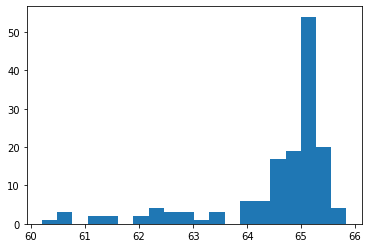

In [400]:
#samples['meanGC'] = samples.apply( lambda x: tools.get_gc(x.filename1, limit=5e4).mean(), 1)
samples.sample(150).meanGC.hist(bins=20,grid=False)

<AxesSubplot:xlabel='name', ylabel='sample'>

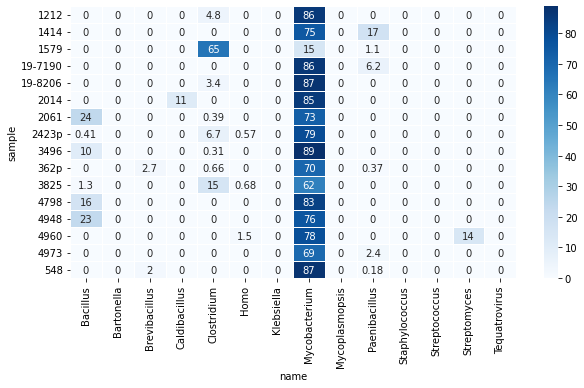

In [387]:
x=found[found.rank_code=='G']
contam = x.pivot_table(index='sample',columns='name',values='perc_frag').fillna(0)
X=contam[contam.Mycobacterium<90]
#X=X.merge(samples[['sample','meanGC']],left_index=True,right_on='sample')
#X=X.set_index(['sample','meanGC'])

ax=plt.subplots(1,1,figsize=(10,5))
sns.heatmap(X,lw=1,cmap='Blues',annot=True)

[mpileup] 1 samples in 1 input files
[mpileup] 1 samples in 1 input files
[mpileup] 1 samples in 1 input files
[mpileup] 1 samples in 1 input files
[mpileup] 1 samples in 1 input files
[mpileup] 1 samples in 1 input files
[mpileup] 1 samples in 1 input files
[mpileup] 1 samples in 1 input files
[mpileup] 1 samples in 1 input files
[mpileup] 1 samples in 1 input files
[mpileup] 1 samples in 1 input files
[mpileup] 1 samples in 1 input files
[mpileup] 1 samples in 1 input files
[mpileup] 1 samples in 1 input files
[mpileup] 1 samples in 1 input files
[mpileup] 1 samples in 1 input files
[mpileup] 1 samples in 1 input files
[mpileup] 1 samples in 1 input files


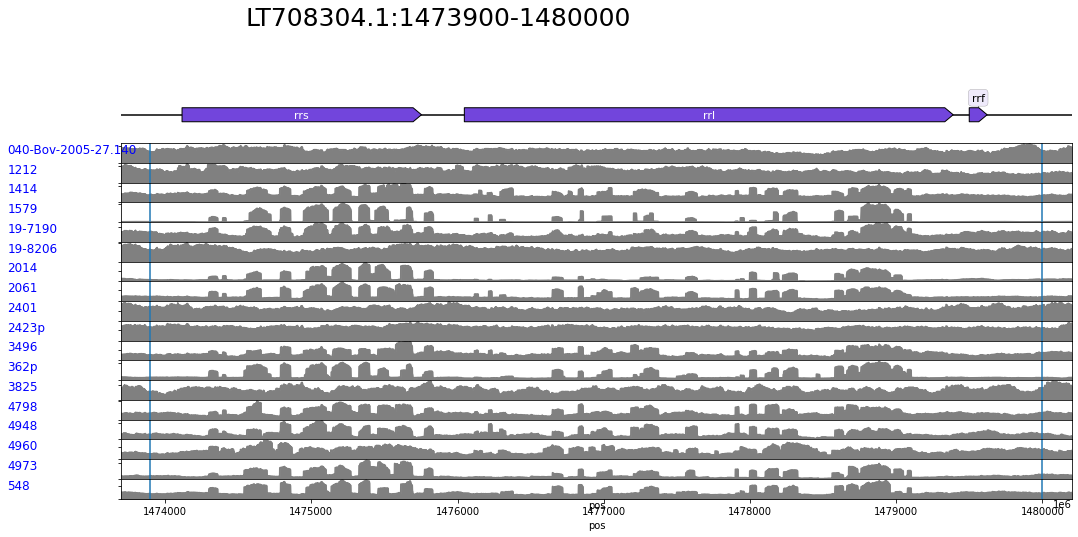

In [379]:
s1 = samples.sample(5)
other=['2401','3825','040-Bov-2005-27.140']
s = samples[samples['sample'].isin(clnames+other)]
start=1473900
end=1480000
rdiff.show_coverage(s,'LT708304.1',start,end,app.mbovis_genome,app.mbovis_gb,minq=0,
                      labelcol='sample',margin=200)

In [20]:
reload(app)
reload(tools)
app.fetch_contam_file()
app.blast_contaminants(f1,limit=5000)

,hits,perc_hits
Mycobacterium bovis,3317,66.34
Paenibacillus polymyxa,14,0.28


In [ ]:
reload(tools)
seqs = fastq_to_rec(f1,1000)
SeqIO.write(seqs,'1579.fa','fasta')


In [366]:
app.blast_contaminants(f2)

,hits,perc_hits
Clostridium_tyrobutyricum,1266,63.3
Mycobacterium_bovis,290,14.5
Paenibacillus_polymyxa,14,0.7
Clostridium_argentinense,10,0.5


In [255]:
def make_contam_targets(species=None, path=None):
    """Create targets from contaminant seqs for removal with bwa"""
    
    new = []    
    seqs = SeqIO.parse('contam_genomes/contam.fa','fasta')
    for seq in seqs:
        title = seq.description.split('__')[0]
        #print (title)
        if species == None:
            #don't include reference
            if title != 'Mycobacterium_bovis':
                new.append(seq)
        elif title in species:
            print (title)
            new.append(seq)
    if path==None:
        path=tempfile.tempdir
    filename = os.path.join(path,'removal.fa')
    SeqIO.write(new,filename,'fasta')
    return filename

make_contam_targets(path=app.sequence_path,species=['Clostridium_tyrobutyricum'])

Clostridium_tyrobutyricum


'/home/farrell/.config/snipgenie/genome/removal.fa'

In [351]:
# this doesn't work!!
reload(aligners)
def remove_contaminants(f1, f2, outdir, species=None, threads=4):
    """Remove specified sequences from fastq files and keep unmapped"""
    
    targets = make_contam_targets(path=app.sequence_path, species=species)
    aligners.build_bwa_index(targets)   
    tmp = os.path.join(tempfile.tempdir,'contam_removal.bam')
    idx = os.path.join(app.sequence_path,'removal.fa')
    aligners.bwa_align(f1, f2, idx=idx, out=tmp, unmapped=outdir, threads=threads, overwrite=True)
    os.remove(tmp)
    return


In [ ]:
cleaned = '/storage/btbgenie/monaghan/cleaned2'
remove_contaminants(f1, f2, cleaned, species=['Clostridium_tyrobutyricum'])#, 'Paenibacillus_polymyxa'])

In [259]:
clnames=list(X.index)
csamples = samples[samples['sample'].isin(cleaned)]
for i,r in csamples.iterrows():
    remove_contaminants(r.filename1, r.filename2, cleaned, threads=8)

[M::mem_pestat] # candidate unique pairs for (FF, FR, RF, RR): (10, 68440, 28, 15)
[M::mem_pestat] analyzing insert size distribution for orientation FF...
[M::mem_pestat] (25, 50, 75) percentile: (147, 212, 402)
[M::mem_pestat] low and high boundaries for computing mean and std.dev: (1, 912)
[M::mem_pestat] mean and std.dev: (231.00, 113.00)
[M::mem_pestat] low and high boundaries for proper pairs: (1, 1167)
[M::mem_pestat] analyzing insert size distribution for orientation FR...
[M::mem_pestat] (25, 50, 75) percentile: (218, 286, 357)
[M::mem_pestat] low and high boundaries for computing mean and std.dev: (1, 635)
[M::mem_pestat] mean and std.dev: (287.31, 107.95)
[M::mem_pestat] low and high boundaries for proper pairs: (1, 774)
[M::mem_pestat] analyzing insert size distribution for orientation RF...
[M::mem_pestat] (25, 50, 75) percentile: (304, 1434, 2491)
[M::mem_pestat] low and high boundaries for computing mean and std.dev: (1, 6865)
[M::mem_pestat] mean and std.dev: (1317.12, 

samtools view -b -f12 /tmp/contam_removal.bam | samtools fastq -1 cleaned/2061_S59_L001-4_R1_001.fastq.gz -2 cleaned/2061_S59_L001-4_R2_001.fastq.gz


[M::bam2fq_mainloop] discarded 0 singletons
[M::bam2fq_mainloop] processed 2506362 reads
[bwa_index] Pack FASTA... 0.15 sec
[bwa_index] Construct BWT for the packed sequence...
[BWTIncCreate] textLength=87866752, availableWord=18182240
[BWTIncConstructFromPacked] 10 iterations done. 29991792 characters processed.
[BWTIncConstructFromPacked] 20 iterations done. 55405792 characters processed.
[BWTIncConstructFromPacked] 30 iterations done. 77989824 characters processed.
[bwt_gen] Finished constructing BWT in 35 iterations.
[bwa_index] 12.39 seconds elapse.
[bwa_index] Update BWT... 0.15 sec
[bwa_index] Pack forward-only FASTA... 0.11 sec
[bwa_index] Construct SA from BWT and Occ... 6.32 sec
[main] Version: 0.7.17-r1188
[main] CMD: bwa index /home/farrell/.config/snipgenie/genome/removal.fa
[main] Real time: 19.191 sec; CPU: 19.114 sec
[M::bwa_idx_load_from_disk] read 0 ALT contigs


bwa index /home/farrell/.config/snipgenie/genome/removal.fa
bwa mem -M -t 8  /home/farrell/.config/snipgenie/genome/removal.fa "/storage/btbgenie/mbovis_ireland/Monaghan/Fastqs_29-07-19/2423p_S29_L001-4_R1_001.fastq.gz" "/storage/btbgenie/mbovis_ireland/Monaghan/Fastqs_29-07-19/2423p_S29_L001-4_R2_001.fastq.gz" | samtools view  -bt - | samtools sort -o /tmp/contam_removal.bam


[M::process] read 546676 sequences (80000281 bp)...
[M::process] read 548190 sequences (80000029 bp)...
[M::mem_pestat] # candidate unique pairs for (FF, FR, RF, RR): (3, 16200, 19, 6)
[M::mem_pestat] skip orientation FF as there are not enough pairs
[M::mem_pestat] analyzing insert size distribution for orientation FR...
[M::mem_pestat] (25, 50, 75) percentile: (87, 157, 229)
[M::mem_pestat] low and high boundaries for computing mean and std.dev: (1, 513)
[M::mem_pestat] mean and std.dev: (164.71, 93.37)
[M::mem_pestat] low and high boundaries for proper pairs: (1, 655)
[M::mem_pestat] analyzing insert size distribution for orientation RF...
[M::mem_pestat] (25, 50, 75) percentile: (1438, 2395, 2608)
[M::mem_pestat] low and high boundaries for computing mean and std.dev: (1, 4948)
[M::mem_pestat] mean and std.dev: (1995.50, 762.83)
[M::mem_pestat] low and high boundaries for proper pairs: (1, 6118)
[M::mem_pestat] skip orientation RR as there are not enough pairs
[M::mem_pestat] skip 

samtools view -b -f12 /tmp/contam_removal.bam | samtools fastq -1 cleaned/2423p_S29_L001-4_R1_001.fastq.gz -2 cleaned/2423p_S29_L001-4_R2_001.fastq.gz


[M::bam2fq_mainloop] discarded 0 singletons
[M::bam2fq_mainloop] processed 4422614 reads
[bwa_index] Pack FASTA... 0.15 sec
[bwa_index] Construct BWT for the packed sequence...
[BWTIncCreate] textLength=87866752, availableWord=18182240
[BWTIncConstructFromPacked] 10 iterations done. 29991792 characters processed.
[BWTIncConstructFromPacked] 20 iterations done. 55405792 characters processed.
[BWTIncConstructFromPacked] 30 iterations done. 77989824 characters processed.
[bwt_gen] Finished constructing BWT in 35 iterations.
[bwa_index] 12.33 seconds elapse.
[bwa_index] Update BWT... 0.15 sec
[bwa_index] Pack forward-only FASTA... 0.10 sec
[bwa_index] Construct SA from BWT and Occ... 6.08 sec
[main] Version: 0.7.17-r1188
[main] CMD: bwa index /home/farrell/.config/snipgenie/genome/removal.fa
[main] Real time: 18.880 sec; CPU: 18.800 sec
[M::bwa_idx_load_from_disk] read 0 ALT contigs


bwa index /home/farrell/.config/snipgenie/genome/removal.fa
bwa mem -M -t 8  /home/farrell/.config/snipgenie/genome/removal.fa "/storage/btbgenie/mbovis_ireland/Monaghan/Fastqs_24-09-19/3496_S83_L001-4_R1_001.fastq.gz" "/storage/btbgenie/mbovis_ireland/Monaghan/Fastqs_24-09-19/3496_S83_L001-4_R2_001.fastq.gz" | samtools view  -bt - | samtools sort -o /tmp/contam_removal.bam


[M::process] read 538630 sequences (80000134 bp)...
[M::process] read 538174 sequences (80000257 bp)...
[M::mem_pestat] # candidate unique pairs for (FF, FR, RF, RR): (22, 41489, 19, 11)
[M::mem_pestat] analyzing insert size distribution for orientation FF...
[M::mem_pestat] (25, 50, 75) percentile: (208, 430, 1621)
[M::mem_pestat] low and high boundaries for computing mean and std.dev: (1, 4447)
[M::mem_pestat] mean and std.dev: (1223.05, 1276.09)
[M::mem_pestat] low and high boundaries for proper pairs: (1, 6327)
[M::mem_pestat] analyzing insert size distribution for orientation FR...
[M::mem_pestat] (25, 50, 75) percentile: (179, 252, 327)
[M::mem_pestat] low and high boundaries for computing mean and std.dev: (1, 623)
[M::mem_pestat] mean and std.dev: (254.04, 112.53)
[M::mem_pestat] low and high boundaries for proper pairs: (1, 771)
[M::mem_pestat] analyzing insert size distribution for orientation RF...
[M::mem_pestat] (25, 50, 75) percentile: (561, 1434, 2395)
[M::mem_pestat] lo

samtools view -b -f12 /tmp/contam_removal.bam | samtools fastq -1 cleaned/3496_S83_L001-4_R1_001.fastq.gz -2 cleaned/3496_S83_L001-4_R2_001.fastq.gz


[M::bam2fq_mainloop] discarded 0 singletons
[M::bam2fq_mainloop] processed 849242 reads
[bwa_index] Pack FASTA... 0.15 sec
[bwa_index] Construct BWT for the packed sequence...
[BWTIncCreate] textLength=87866752, availableWord=18182240
[BWTIncConstructFromPacked] 10 iterations done. 29991792 characters processed.
[BWTIncConstructFromPacked] 20 iterations done. 55405792 characters processed.
[BWTIncConstructFromPacked] 30 iterations done. 77989824 characters processed.
[bwt_gen] Finished constructing BWT in 35 iterations.
[bwa_index] 12.32 seconds elapse.
[bwa_index] Update BWT... 0.15 sec
[bwa_index] Pack forward-only FASTA... 0.10 sec
[bwa_index] Construct SA from BWT and Occ... 6.07 sec
[main] Version: 0.7.17-r1188
[main] CMD: bwa index /home/farrell/.config/snipgenie/genome/removal.fa
[main] Real time: 18.874 sec; CPU: 18.786 sec
[M::bwa_idx_load_from_disk] read 0 ALT contigs


bwa index /home/farrell/.config/snipgenie/genome/removal.fa
bwa mem -M -t 8  /home/farrell/.config/snipgenie/genome/removal.fa "/storage/btbgenie/mbovis_ireland/Monaghan/Fastqs_29-07-19/362p_S18_L001-4_R1_001.fastq.gz" "/storage/btbgenie/mbovis_ireland/Monaghan/Fastqs_29-07-19/362p_S18_L001-4_R2_001.fastq.gz" | samtools view  -bt - | samtools sort -o /tmp/contam_removal.bam


[M::process] read 535894 sequences (80000004 bp)...
[M::process] read 536458 sequences (80000177 bp)...
[M::mem_pestat] # candidate unique pairs for (FF, FR, RF, RR): (5, 11620, 21, 5)
[M::mem_pestat] skip orientation FF as there are not enough pairs
[M::mem_pestat] analyzing insert size distribution for orientation FR...
[M::mem_pestat] (25, 50, 75) percentile: (132, 224, 319)
[M::mem_pestat] low and high boundaries for computing mean and std.dev: (1, 693)
[M::mem_pestat] mean and std.dev: (231.21, 128.52)
[M::mem_pestat] low and high boundaries for proper pairs: (1, 880)
[M::mem_pestat] analyzing insert size distribution for orientation RF...
[M::mem_pestat] (25, 50, 75) percentile: (798, 2398, 2633)
[M::mem_pestat] low and high boundaries for computing mean and std.dev: (1, 6303)
[M::mem_pestat] mean and std.dev: (1710.42, 883.97)
[M::mem_pestat] low and high boundaries for proper pairs: (1, 8138)
[M::mem_pestat] skip orientation RR as there are not enough pairs
[M::mem_pestat] skip

samtools view -b -f12 /tmp/contam_removal.bam | samtools fastq -1 cleaned/362p_S18_L001-4_R1_001.fastq.gz -2 cleaned/362p_S18_L001-4_R2_001.fastq.gz


[M::bam2fq_mainloop] discarded 0 singletons
[M::bam2fq_mainloop] processed 5767352 reads
[bwa_index] Pack FASTA... 0.16 sec
[bwa_index] Construct BWT for the packed sequence...
[BWTIncCreate] textLength=87866752, availableWord=18182240
[BWTIncConstructFromPacked] 10 iterations done. 29991792 characters processed.
[BWTIncConstructFromPacked] 20 iterations done. 55405792 characters processed.
[BWTIncConstructFromPacked] 30 iterations done. 77989824 characters processed.
[bwt_gen] Finished constructing BWT in 35 iterations.
[bwa_index] 12.43 seconds elapse.
[bwa_index] Update BWT... 0.15 sec
[bwa_index] Pack forward-only FASTA... 0.10 sec
[bwa_index] Construct SA from BWT and Occ... 6.11 sec
[main] Version: 0.7.17-r1188
[main] CMD: bwa index /home/farrell/.config/snipgenie/genome/removal.fa
[main] Real time: 19.022 sec; CPU: 18.950 sec
[M::bwa_idx_load_from_disk] read 0 ALT contigs


bwa index /home/farrell/.config/snipgenie/genome/removal.fa
bwa mem -M -t 8  /home/farrell/.config/snipgenie/genome/removal.fa "/storage/btbgenie/mbovis_ireland/Monaghan/Fastqs_24-09-19/3825_S62_L001-4_R1_001.fastq.gz" "/storage/btbgenie/mbovis_ireland/Monaghan/Fastqs_24-09-19/3825_S62_L001-4_R2_001.fastq.gz" | samtools view  -bt - | samtools sort -o /tmp/contam_removal.bam


[M::process] read 545078 sequences (80000206 bp)...
[M::process] read 479970 sequences (70493492 bp)...
[M::mem_pestat] # candidate unique pairs for (FF, FR, RF, RR): (6, 9367, 17, 7)
[M::mem_pestat] skip orientation FF as there are not enough pairs
[M::mem_pestat] analyzing insert size distribution for orientation FR...
[M::mem_pestat] (25, 50, 75) percentile: (175, 275, 371)
[M::mem_pestat] low and high boundaries for computing mean and std.dev: (1, 763)
[M::mem_pestat] mean and std.dev: (278.16, 143.60)
[M::mem_pestat] low and high boundaries for proper pairs: (1, 959)
[M::mem_pestat] analyzing insert size distribution for orientation RF...
[M::mem_pestat] (25, 50, 75) percentile: (1434, 2218, 2687)
[M::mem_pestat] low and high boundaries for computing mean and std.dev: (1, 5193)
[M::mem_pestat] mean and std.dev: (1617.86, 855.00)
[M::mem_pestat] low and high boundaries for proper pairs: (1, 6446)
[M::mem_pestat] skip orientation RR as there are not enough pairs
[M::mem_pestat] skip

samtools view -b -f12 /tmp/contam_removal.bam | samtools fastq -1 cleaned/3825_S62_L001-4_R1_001.fastq.gz -2 cleaned/3825_S62_L001-4_R2_001.fastq.gz


[M::bam2fq_mainloop] discarded 0 singletons
[M::bam2fq_mainloop] processed 863590 reads
[bwa_index] Pack FASTA... 0.15 sec
[bwa_index] Construct BWT for the packed sequence...
[BWTIncCreate] textLength=87866752, availableWord=18182240
[BWTIncConstructFromPacked] 10 iterations done. 29991792 characters processed.
[BWTIncConstructFromPacked] 20 iterations done. 55405792 characters processed.
[BWTIncConstructFromPacked] 30 iterations done. 77989824 characters processed.
[bwt_gen] Finished constructing BWT in 35 iterations.
[bwa_index] 12.28 seconds elapse.
[bwa_index] Update BWT... 0.15 sec
[bwa_index] Pack forward-only FASTA... 0.11 sec
[bwa_index] Construct SA from BWT and Occ... 6.13 sec
[main] Version: 0.7.17-r1188
[main] CMD: bwa index /home/farrell/.config/snipgenie/genome/removal.fa
[main] Real time: 18.906 sec; CPU: 18.821 sec
[M::bwa_idx_load_from_disk] read 0 ALT contigs


bwa index /home/farrell/.config/snipgenie/genome/removal.fa
bwa mem -M -t 8  /home/farrell/.config/snipgenie/genome/removal.fa "/storage/btbgenie/mbovis_ireland/Monaghan/Fastqs_24-09-19/4798_S58_L001-4_R1_001.fastq.gz" "/storage/btbgenie/mbovis_ireland/Monaghan/Fastqs_24-09-19/4798_S58_L001-4_R2_001.fastq.gz" | samtools view  -bt - | samtools sort -o /tmp/contam_removal.bam


[M::process] read 541988 sequences (80000268 bp)...
[M::process] read 541914 sequences (80000193 bp)...
[M::mem_pestat] # candidate unique pairs for (FF, FR, RF, RR): (8, 58932, 20, 13)
[M::mem_pestat] skip orientation FF as there are not enough pairs
[M::mem_pestat] analyzing insert size distribution for orientation FR...
[M::mem_pestat] (25, 50, 75) percentile: (155, 218, 281)
[M::mem_pestat] low and high boundaries for computing mean and std.dev: (1, 533)
[M::mem_pestat] mean and std.dev: (220.92, 96.17)
[M::mem_pestat] low and high boundaries for proper pairs: (1, 659)
[M::mem_pestat] analyzing insert size distribution for orientation RF...
[M::mem_pestat] (25, 50, 75) percentile: (435, 860, 2395)
[M::mem_pestat] low and high boundaries for computing mean and std.dev: (1, 6315)
[M::mem_pestat] mean and std.dev: (1029.79, 869.13)
[M::mem_pestat] low and high boundaries for proper pairs: (1, 8275)
[M::mem_pestat] analyzing insert size distribution for orientation RR...
[M::mem_pestat

samtools view -b -f12 /tmp/contam_removal.bam | samtools fastq -1 cleaned/4798_S58_L001-4_R1_001.fastq.gz -2 cleaned/4798_S58_L001-4_R2_001.fastq.gz


[M::bam2fq_mainloop] discarded 0 singletons
[M::bam2fq_mainloop] processed 874676 reads
[bwa_index] Pack FASTA... 0.14 sec
[bwa_index] Construct BWT for the packed sequence...
[BWTIncCreate] textLength=87866752, availableWord=18182240
[BWTIncConstructFromPacked] 10 iterations done. 29991792 characters processed.
[BWTIncConstructFromPacked] 20 iterations done. 55405792 characters processed.
[BWTIncConstructFromPacked] 30 iterations done. 77989824 characters processed.
[bwt_gen] Finished constructing BWT in 35 iterations.
[bwa_index] 12.19 seconds elapse.
[bwa_index] Update BWT... 0.15 sec
[bwa_index] Pack forward-only FASTA... 0.10 sec
[bwa_index] Construct SA from BWT and Occ... 6.23 sec
[main] Version: 0.7.17-r1188
[main] CMD: bwa index /home/farrell/.config/snipgenie/genome/removal.fa
[main] Real time: 18.889 sec; CPU: 18.817 sec
[M::bwa_idx_load_from_disk] read 0 ALT contigs


bwa index /home/farrell/.config/snipgenie/genome/removal.fa
bwa mem -M -t 8  /home/farrell/.config/snipgenie/genome/removal.fa "/storage/btbgenie/mbovis_ireland/Monaghan/Fastqs_24-09-19/4948_S8_L001-4_R1_001.fastq.gz" "/storage/btbgenie/mbovis_ireland/Monaghan/Fastqs_24-09-19/4948_S8_L001-4_R2_001.fastq.gz" | samtools view  -bt - | samtools sort -o /tmp/contam_removal.bam


[M::process] read 541928 sequences (80000071 bp)...
[M::process] read 64754 sequences (9543186 bp)...
[M::mem_pestat] # candidate unique pairs for (FF, FR, RF, RR): (11, 69580, 21, 15)
[M::mem_pestat] analyzing insert size distribution for orientation FF...
[M::mem_pestat] (25, 50, 75) percentile: (292, 345, 751)
[M::mem_pestat] low and high boundaries for computing mean and std.dev: (1, 1669)
[M::mem_pestat] mean and std.dev: (444.00, 332.79)
[M::mem_pestat] low and high boundaries for proper pairs: (1, 2128)
[M::mem_pestat] analyzing insert size distribution for orientation FR...
[M::mem_pestat] (25, 50, 75) percentile: (243, 362, 449)
[M::mem_pestat] low and high boundaries for computing mean and std.dev: (1, 861)
[M::mem_pestat] mean and std.dev: (345.15, 146.23)
[M::mem_pestat] low and high boundaries for proper pairs: (1, 1067)
[M::mem_pestat] analyzing insert size distribution for orientation RF...
[M::mem_pestat] (25, 50, 75) percentile: (534, 1091, 4547)
[M::mem_pestat] low an

samtools view -b -f12 /tmp/contam_removal.bam | samtools fastq -1 cleaned/4948_S8_L001-4_R1_001.fastq.gz -2 cleaned/4948_S8_L001-4_R2_001.fastq.gz


[M::bam2fq_mainloop] discarded 0 singletons
[M::bam2fq_mainloop] processed 358154 reads
[bwa_index] Pack FASTA... 0.15 sec
[bwa_index] Construct BWT for the packed sequence...
[BWTIncCreate] textLength=87866752, availableWord=18182240
[BWTIncConstructFromPacked] 10 iterations done. 29991792 characters processed.
[BWTIncConstructFromPacked] 20 iterations done. 55405792 characters processed.
[BWTIncConstructFromPacked] 30 iterations done. 77989824 characters processed.
[bwt_gen] Finished constructing BWT in 35 iterations.
[bwa_index] 12.16 seconds elapse.
[bwa_index] Update BWT... 0.14 sec
[bwa_index] Pack forward-only FASTA... 0.10 sec
[bwa_index] Construct SA from BWT and Occ... 5.96 sec
[main] Version: 0.7.17-r1188
[main] CMD: bwa index /home/farrell/.config/snipgenie/genome/removal.fa
[main] Real time: 18.589 sec; CPU: 18.522 sec
[M::bwa_idx_load_from_disk] read 0 ALT contigs


bwa index /home/farrell/.config/snipgenie/genome/removal.fa
bwa mem -M -t 8  /home/farrell/.config/snipgenie/genome/removal.fa "/storage/btbgenie/mbovis_ireland/Monaghan/Fastqs_24-09-19/4960_S92_L001-4_R1_001.fastq.gz" "/storage/btbgenie/mbovis_ireland/Monaghan/Fastqs_24-09-19/4960_S92_L001-4_R2_001.fastq.gz" | samtools view  -bt - | samtools sort -o /tmp/contam_removal.bam


[M::process] read 553968 sequences (80000190 bp)...
[M::process] read 552496 sequences (80000136 bp)...
[M::mem_pestat] # candidate unique pairs for (FF, FR, RF, RR): (9, 15464, 16, 8)
[M::mem_pestat] skip orientation FF as there are not enough pairs
[M::mem_pestat] analyzing insert size distribution for orientation FR...
[M::mem_pestat] (25, 50, 75) percentile: (92, 181, 275)
[M::mem_pestat] low and high boundaries for computing mean and std.dev: (1, 641)
[M::mem_pestat] mean and std.dev: (192.97, 119.43)
[M::mem_pestat] low and high boundaries for proper pairs: (1, 824)
[M::mem_pestat] analyzing insert size distribution for orientation RF...
[M::mem_pestat] (25, 50, 75) percentile: (1434, 2394, 2608)
[M::mem_pestat] low and high boundaries for computing mean and std.dev: (1, 4956)
[M::mem_pestat] mean and std.dev: (1807.33, 805.64)
[M::mem_pestat] low and high boundaries for proper pairs: (1, 6130)
[M::mem_pestat] skip orientation RR as there are not enough pairs
[M::mem_pestat] skip

samtools view -b -f12 /tmp/contam_removal.bam | samtools fastq -1 cleaned/4960_S92_L001-4_R1_001.fastq.gz -2 cleaned/4960_S92_L001-4_R2_001.fastq.gz


[M::bam2fq_mainloop] discarded 0 singletons
[M::bam2fq_mainloop] processed 970512 reads
[bwa_index] Pack FASTA... 0.16 sec
[bwa_index] Construct BWT for the packed sequence...
[BWTIncCreate] textLength=87866752, availableWord=18182240
[BWTIncConstructFromPacked] 10 iterations done. 29991792 characters processed.
[BWTIncConstructFromPacked] 20 iterations done. 55405792 characters processed.
[BWTIncConstructFromPacked] 30 iterations done. 77989824 characters processed.
[bwt_gen] Finished constructing BWT in 35 iterations.
[bwa_index] 14.05 seconds elapse.
[bwa_index] Update BWT... 0.15 sec
[bwa_index] Pack forward-only FASTA... 0.11 sec
[bwa_index] Construct SA from BWT and Occ... 6.49 sec
[main] Version: 0.7.17-r1188
[main] CMD: bwa index /home/farrell/.config/snipgenie/genome/removal.fa
[main] Real time: 21.024 sec; CPU: 20.956 sec
[M::bwa_idx_load_from_disk] read 0 ALT contigs


bwa index /home/farrell/.config/snipgenie/genome/removal.fa
bwa mem -M -t 8  /home/farrell/.config/snipgenie/genome/removal.fa "/storage/btbgenie/mbovis_ireland/Monaghan/Fastqs_24-09-19/4973_S49_L001-4_R1_001.fastq.gz" "/storage/btbgenie/mbovis_ireland/Monaghan/Fastqs_24-09-19/4973_S49_L001-4_R2_001.fastq.gz" | samtools view  -bt - | samtools sort -o /tmp/contam_removal.bam


[M::process] read 538228 sequences (80000104 bp)...
[M::process] read 537886 sequences (80000057 bp)...
[M::mem_pestat] # candidate unique pairs for (FF, FR, RF, RR): (6, 12439, 14, 11)
[M::mem_pestat] skip orientation FF as there are not enough pairs
[M::mem_pestat] analyzing insert size distribution for orientation FR...
[M::mem_pestat] (25, 50, 75) percentile: (115, 214, 314)
[M::mem_pestat] low and high boundaries for computing mean and std.dev: (1, 712)
[M::mem_pestat] mean and std.dev: (224.53, 135.79)
[M::mem_pestat] low and high boundaries for proper pairs: (1, 911)
[M::mem_pestat] analyzing insert size distribution for orientation RF...
[M::mem_pestat] (25, 50, 75) percentile: (531, 1434, 2395)
[M::mem_pestat] low and high boundaries for computing mean and std.dev: (1, 6123)
[M::mem_pestat] mean and std.dev: (1368.92, 903.95)
[M::mem_pestat] low and high boundaries for proper pairs: (1, 7987)
[M::mem_pestat] analyzing insert size distribution for orientation RR...
[M::mem_pest

samtools view -b -f12 /tmp/contam_removal.bam | samtools fastq -1 cleaned/4973_S49_L001-4_R1_001.fastq.gz -2 cleaned/4973_S49_L001-4_R2_001.fastq.gz


[M::bam2fq_mainloop] discarded 0 singletons
[M::bam2fq_mainloop] processed 908390 reads
[bwa_index] Pack FASTA... 0.16 sec
[bwa_index] Construct BWT for the packed sequence...
[BWTIncCreate] textLength=87866752, availableWord=18182240
[BWTIncConstructFromPacked] 10 iterations done. 29991792 characters processed.
[BWTIncConstructFromPacked] 20 iterations done. 55405792 characters processed.
[BWTIncConstructFromPacked] 30 iterations done. 77989824 characters processed.
[bwt_gen] Finished constructing BWT in 35 iterations.
[bwa_index] 12.78 seconds elapse.
[bwa_index] Update BWT... 0.15 sec
[bwa_index] Pack forward-only FASTA... 0.10 sec
[bwa_index] Construct SA from BWT and Occ... 6.51 sec
[main] Version: 0.7.17-r1188
[main] CMD: bwa index /home/farrell/.config/snipgenie/genome/removal.fa
[main] Real time: 19.779 sec; CPU: 19.707 sec
[M::bwa_idx_load_from_disk] read 0 ALT contigs


bwa index /home/farrell/.config/snipgenie/genome/removal.fa
bwa mem -M -t 8  /home/farrell/.config/snipgenie/genome/removal.fa "/storage/btbgenie/mbovis_ireland/Monaghan/Fastqs_29-07-19/548_S25_L001-4_R1_001.fastq.gz" "/storage/btbgenie/mbovis_ireland/Monaghan/Fastqs_29-07-19/548_S25_L001-4_R2_001.fastq.gz" | samtools view  -bt - | samtools sort -o /tmp/contam_removal.bam


[M::process] read 535170 sequences (80000228 bp)...
[M::process] read 535712 sequences (80000069 bp)...
[M::mem_pestat] # candidate unique pairs for (FF, FR, RF, RR): (5, 13531, 21, 6)
[M::mem_pestat] skip orientation FF as there are not enough pairs
[M::mem_pestat] analyzing insert size distribution for orientation FR...
[M::mem_pestat] (25, 50, 75) percentile: (146, 242, 327)
[M::mem_pestat] low and high boundaries for computing mean and std.dev: (1, 689)
[M::mem_pestat] mean and std.dev: (242.46, 126.60)
[M::mem_pestat] low and high boundaries for proper pairs: (1, 870)
[M::mem_pestat] analyzing insert size distribution for orientation RF...
[M::mem_pestat] (25, 50, 75) percentile: (1434, 2233, 2633)
[M::mem_pestat] low and high boundaries for computing mean and std.dev: (1, 5031)
[M::mem_pestat] mean and std.dev: (1776.58, 825.16)
[M::mem_pestat] low and high boundaries for proper pairs: (1, 6230)
[M::mem_pestat] skip orientation RR as there are not enough pairs
[M::mem_pestat] ski

samtools view -b -f12 /tmp/contam_removal.bam | samtools fastq -1 cleaned/548_S25_L001-4_R1_001.fastq.gz -2 cleaned/548_S25_L001-4_R2_001.fastq.gz


[M::bam2fq_mainloop] discarded 0 singletons
[M::bam2fq_mainloop] processed 3433264 reads


In [ ]:
args = {'threads':12, 'outdir': cleaned+'/snipgenie_results', 'labelsep':'_',
        'input':[cleaned],
         'species': 'Mbovis-AF212297',
         'custom_filters': True,
         'buildtree':True}
W = app.WorkFlow(**args)
st = W.setup()
W.run()

In [334]:
import toytree
style={"font-size": "16px"}
treefile=cleaned+'/snipgenie_results/tree.newick'
tre = toytree.tree(treefile)
tre = tre.root('ref')
tre=tre.drop_tips('2061')
canvas,t,r=tre.draw(layout='r',tip_labels_style=style,width=1000,height=500,scalebar=True)

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="1000.0px" height="500.0px" viewBox="0 0 1000.0 500.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="t101fcba8df274600abf79d1f60a3f9de"> 19-7190 4948 19-8206 362p 1579 2423p 1414 4973 3825 2014 1212 4798 548 3496 4960 ref 0 10 21 31 41 51 62 72 82 92

In [380]:
clnames=list(X.index)+['ref']
treefile='/storage/btbgenie/monaghan/monaghan_results/tree.newick'
tre = toytree.tree(treefile)
drop=[n for n in tre.get_tip_labels() if n not in clnames]
tre=tre.drop_tips(drop)
tre=tre.drop_tips('2061')
tre = tre.root('ref')
canvas,t,r=tre.draw(layout='r',tip_labels_style=style,width=1000,height=500,scalebar=True)
tre.write(cleaned+'/snipgenie_results/old.newick')

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="1000.0px" height="500.0px" viewBox="0 0 1000.0 500.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="t78f29c9b68b54caa859c33ef1f0a982b"> 19-8206 19-7190 4948 362p 1579 2423p 1414 4973 2014 3825 1212 4798 548 3496 4960 ref 0 12 24 36 48 60 72 83 95 107

In [336]:
muts1 = app.read_csq_file(cleaned+'/snipgenie_results/csq.tsv')
muts2 = app.read_csq_file('/storage/btbgenie/monaghan/monaghan_results/csq.tsv')

In [ ]:
x=pd.read_csv('/storage/btbgenie/monaghan/monaghan_results/csq.matrix',index_col=[0,1,2,3])
x

In [360]:
muts2[muts2.gene=='RRL']

,1,sample,2,chrom,start,snp_type,gene,locus_tag,strand,feature_type,aa,nuc
